# Part I: Profiling expression STRs across 17 human tissues

This notebook contains info for:

#### Figures
* **Figure 1D** causal examples

#### Supplementary Tables:
* **Supplementary Table LITERATURE**

In [4]:
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-calling"
FIGPREFIX = "SuppFig"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
}
TISSUES = COLORS.keys()

############ Load linear regression data #############
data = {} # Map of tissue -> data
for t in TISSUES:
    data[t] = pd.read_csv(os.path.join(DATADIR, "%s_LinearRegression.tab"%t), sep="\t", usecols=[0,1,3,8,11])
    data[t]["str.start"] = (data[t]["str.start"]).apply(int)

Populating the interactive namespace from numpy and matplotlib


In [5]:
# Get best tissue for a given eSTR
PTHRESH = 0.01
def GetBestTissue(chrom, start, gene, data):
    """
    Return tissue, pval, beta
    """
    best_tissue = None
    best_p = 1
    best_beta = None
    for t in data:
        x = data[t]
        x = x[(x["chrom"]==chrom) & (x["str.start"]==start) & (x["gene"]==gene)]
        if x.shape[0] == 0: continue
        if x["p.wald"].values[0] <= best_p:
            best_tissue = t
            best_p = x["p.wald"].values[0]
            best_beta = x["beta"].values[0]
        if  x["p.wald"].values[0] < PTHRESH:
            print("%s %s %s"%(t, x["p.wald"].values[0], x["beta"].values[0]))
    return best_tissue, best_p, best_beta

def ExtractData(gene, chrom, start, tissue):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)
    
def PlotESTR(gene, tissue, chrom, start, end, COLORS, fname=None):
    ExtractData(gene, chrom, start, tissue)
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
        
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
    
    rmgts = []
    for gt in sorted(list(set(data["str"]))):
        if data[data["str"]==gt].shape[0] <3: rmgts.append(gt)
    data = data[data["str"].apply(lambda x: x not in rmgts)]

    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color=COLORS[tissue])
    
    means = data.groupby("str", as_index = False).agg({"expr": np.mean})
    means = means.sort_values("str")
    means["num"] = range(means.shape[0])
    
    ax.plot(means["num"], means["expr"], color="black", marker="o")
    ax.set_xlabel("Allele length (bp)", size=15)
    ax.set_ylabel("Expression - %s"%tissue, size=15)
    ax.set_xticklabels([int(item)+(end-start+2)*2 for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.suptitle("");
    plt.show()
    if fname is not None: fig.savefig(fname)

# CSTB

https://www.ncbi.nlm.nih.gov/pubmed/9126745
repeat involved in EPM1 (progressive myoclonus epilepsy MIM 254800)
mutant alleles contain 60+ copies. normal alleles 2-3 copies

https://www.ncbi.nlm.nih.gov/pubmed/22573514
CSTB causal eQTL. Figure 1B. more repeats = more expression

https://www.ncbi.nlm.nih.gov/pubmed/10441345
propose here the mechanism is altered spacing

WholeBlood 2.1014922735574548e-14 0.4070895467591639
Artery-Aorta 1.9626488165263646e-05 0.30828105920092885
Muscle-Skeletal 1.286148195159528e-21 0.4904589924356517
Nerve-Tibial 7.331667966724233e-14 0.4451180552487229
Skin-SunExposed 1.8756893481002583e-14 0.4296000313279473
Esophagus-Muscularis 2.7563910296998874e-09 0.4020328183061333
Heart-LeftVentricle 1.630030072311266e-11 0.4614220913424358
Thyroid 4.1322697025400756e-16 0.4801373588533952
Artery-Tibial 2.2954051577385685e-15 0.4581644098671728
Skin-NotSunExposed 6.339980281606235e-07 0.3419327648502498
Cells-Transformedfibroblasts 1.4904429779250703e-18 0.5521154466758411
Adipose-Subcutaneous 0.0001891850722444315 0.2290882993859059
Adipose-Visceral 2.4937880117961275e-06 0.33822105996552443


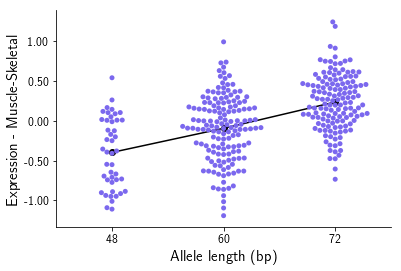

In [3]:
chrom = "chr21"
start = 45196326
end = 45196360
gene = "ENSG00000160213.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CSTB.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PIG3 (TP53I3)

https://www.nature.com/articles/ng836
number of repeats positively correlated with expression, only in the presence of p53 (Figure 5b)

Esophagus-Mucosa 0.008148316941980148 0.1763826888243387
Muscle-Skeletal 0.006844134473106718 0.15480586780044353
Thyroid 0.0006043215012692471 0.2216459057733232


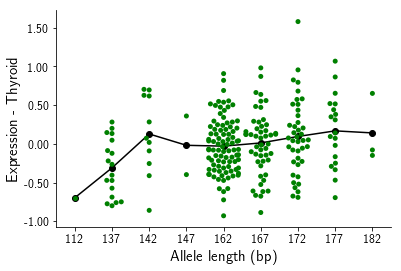

In [4]:
chrom = "chr2"
start = 24307211
end = 24307290
gene = "ENSG00000115129.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PIG3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# MMP9

https://www.ncbi.nlm.nih.gov/pubmed/10428474
polyCA, esophageal carcinoma cell lines
longer repeat = more expression
Figure 3
range tested 0-21 repeats
most Japanese had 20, 21, or 22 repeats

Skin-SunExposed 0.003908333059473693 0.18187989470752275


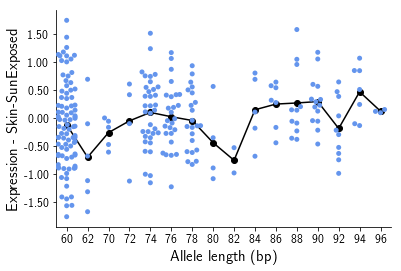

In [5]:
chrom = "chr20"
start = 44637412
end = 44637458
gene = "ENSG00000100985.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MMP9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# EGFR

http://www.jbc.org/content/274/19/13176.long
Figure 4A
16-21 in vivo nonlinear (16 and 20 highest; various cell lines have different numbers)
16-21 in vitro show decreasing trend with expression

Esophagus-Mucosa 0.0017561588027997658 0.21266338120795727
Muscle-Skeletal 0.006974538202550474 0.15839261663021156
Heart-LeftVentricle 0.007359973711983423 -0.20856936945691976


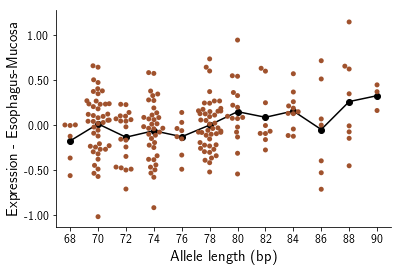

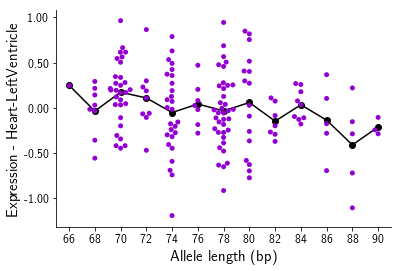

In [6]:
chrom="chr7"
start = 55088253
end = 55088286
gene = "ENSG00000146648.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_EGFR.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)
PlotESTR(gene, "Heart-LeftVentricle", chrom, start, end, COLORS)

# IFNG

https://www.ncbi.nlm.nih.gov/pubmed/15900487

CA12 and CA15 with decreased and increased expression

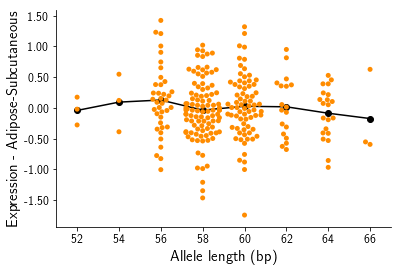

In [7]:
chrom="chr12"
start = 68552495
end = 68552523
gene = "ENSG00000111537.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IFNG.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# UGT1A1
https://www.ncbi.nlm.nih.gov/pubmed/7565971
human hepatoma
longer repeat = reduced expression

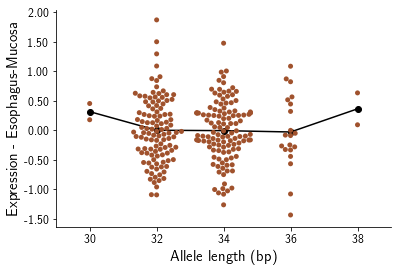

In [8]:
chrom="chr2"
start = 234668880
end = 234668894
gene = "ENSG00000241635.3"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_Gilbert.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# NOP56

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3135815/
expansion causes SCA36

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5504081/
reduced expression in ipscs of patients (bit expansions)

Muscle-Skeletal 7.763973061996127e-12 0.3639638161260791
Skin-SunExposed 5.980036839593017e-05 0.2342239733210593
Thyroid 2.4089756567925805e-08 0.3399550374134861
Artery-Tibial 9.530137450101992e-05 0.2369619492780936
Skin-NotSunExposed 0.003983216894907949 0.20176436491436384
Adipose-Subcutaneous 0.0010882684400698 0.2003387759679452


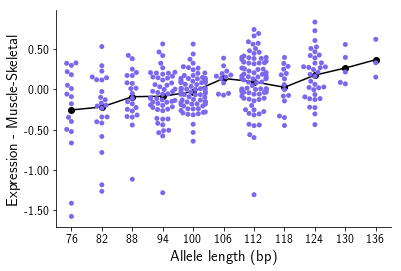

In [9]:
chrom="chr20"
start=2633379
end = 2633421
gene = "ENSG00000101361.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NOP56.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VLDLR

WholeBlood 8.626591585226099e-14 -0.3958859573307789


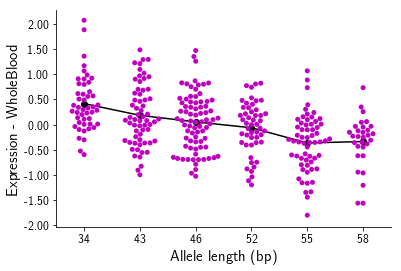

In [42]:
gene = "ENSG00000147852.11"
chrom = "chr9"
start = 2622147
end = 2622171

best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VLDLR.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# Jacobsen Syndrome

Cells-Transformedfibroblasts 0.0039303911901327464 -0.1968094713500796


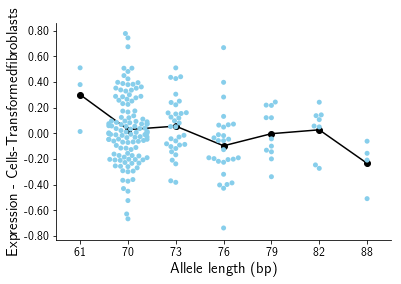

In [43]:
gene = "ENSG00000110395.4"
chrom = "chr11"
start = 119077000
end = 119077033
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CBL.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# ALOX5


Esophagus-Mucosa 4.347912095386305e-07 0.31737116597155063
Skin-SunExposed 0.0009001337755839648 -0.1939411613489228
Brain-Cerebellum 0.00270767041900817 0.28984312234623305


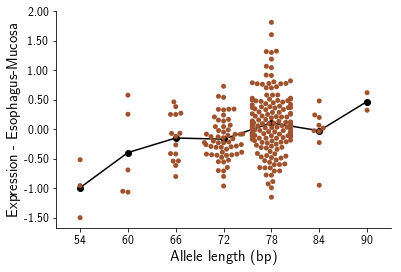

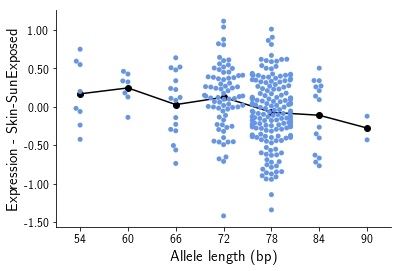

In [12]:
gene = "ENSG00000012779.6"
chrom = "chr10"
start = 45869548
end = 45869585
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ALOX5.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)
PlotESTR(gene, "Skin-SunExposed", chrom, start, end, COLORS)

# Below are additional examples where expression is not directly tested

# SCNA
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6054541/

repeat length pos relationship with expression
increases binding of nearby TF sites
don't directly test expression

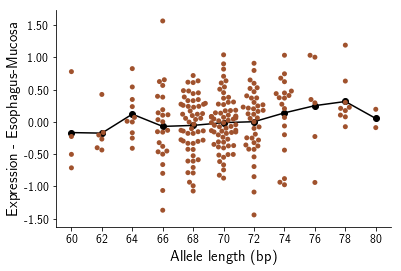

In [13]:
chrom = "chr4"
start = 90636808
end = 90636841
gene = "ENSG00000145335.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SNCA.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# MED19
SCZ GWAS

Esophagus-Mucosa 0.0009307086562075193 0.21064297957710576
WholeBlood 6.7522373268889225e-06 0.25095034233973673
Lung 2.317680069611306e-05 0.2662823032204029
Muscle-Skeletal 3.076008055024236e-06 0.2570274444414629
Nerve-Tibial 0.006461190967527226 0.17391090281358682
Skin-SunExposed 2.222394868570618e-08 0.3243412364155367
Esophagus-Muscularis 7.660486142644615e-06 0.3097394722752356
Thyroid 3.56528538544888e-06 0.289474257550456
Artery-Tibial 4.24800374243584e-06 0.2808033233289799
Brain-Cerebellum 0.001094820593753201 0.3218102727074496
Skin-NotSunExposed 3.105393422347143e-07 0.3557436264552488
Cells-Transformedfibroblasts 0.0031928696792304346 0.2011447570096183
Adipose-Subcutaneous 1.2963494023108917e-12 0.4274209626958312
Adipose-Visceral 3.3148010278500404e-06 0.3368927107214041


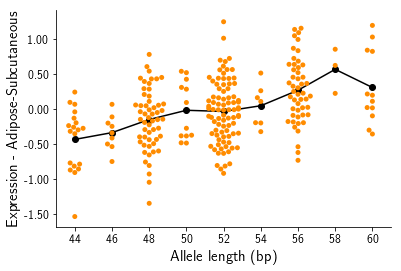

In [44]:
chrom = "chr11"
start = 57523883
end = 57523905
gene = "ENSG00000156603.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MED19.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# APH1A
asd gwas

Cells-Transformedfibroblasts 0.0006438921284489278 0.2273044301068341


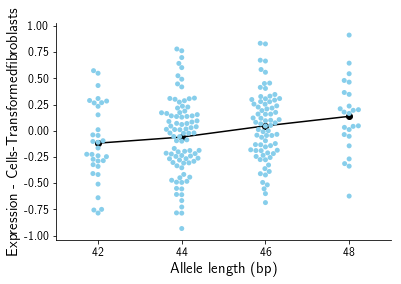

In [45]:
chrom = "chr1"
start = 150314982
end = 150315002
gene = "ENSG00000117362.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_APH1A.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CTNNAL1
SCZ

Muscle-Skeletal 2.869803274614037e-07 0.2755512900292073
Nerve-Tibial 5.747129307451379e-24 0.5735482666210903
Skin-SunExposed 4.725819509292028e-06 0.2628752751338485
Esophagus-Muscularis 2.5748588799007324e-06 0.3193780561698013
Heart-LeftVentricle 0.002947739241851709 0.21185073700072168
Artery-Tibial 2.17428046202e-10 0.3759403678100949
Skin-NotSunExposed 1.9027582638894875e-08 0.3826830819222248
Cells-Transformedfibroblasts 7.358800178348387e-05 0.2646113776994448
Adipose-Subcutaneous 4.1530073587584525e-06 0.2790078836863977
Adipose-Visceral 0.0014720193577126956 0.2303451134950224


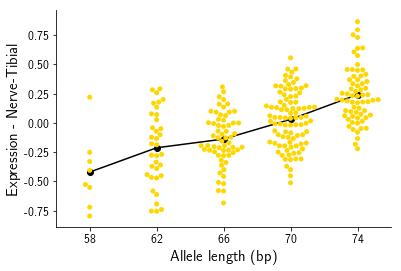

In [17]:
chrom = "chr9"
start = 111783775
end = 111783810
gene = "ENSG00000119326.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CTNNAL1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# ATHL1
multiple gwas hits

Esophagus-Mucosa 2.3938299208472997e-12 0.4331028891611895
WholeBlood 1.553262161119689e-05 0.24271702244845594
Lung 2.0880797347754893e-11 0.4157705525694744
Brain-Caudate 5.8518269987856424e-05 0.3925440390713856
Artery-Aorta 6.539920747305734e-11 0.4656526310391155
Muscle-Skeletal 5.0513096348832675e-20 0.4847069388880421
Nerve-Tibial 4.887620833259244e-18 0.5192112657096155
Skin-SunExposed 4.115412584916311e-20 0.5143799846475999
Esophagus-Muscularis 1.4333476065545024e-18 0.5704144310164405
Heart-LeftVentricle 3.9098688118819607e-14 0.5261591011226466
Thyroid 1.484952132847115e-12 0.4319031988281054
Artery-Tibial 1.5680091369527615e-19 0.5266964967794068
Brain-Cerebellum 8.379104896879828e-05 0.3848591971605152
Skin-NotSunExposed 1.5555424595721646e-13 0.5022100623258655
Cells-Transformedfibroblasts 2.4098787275960903e-10 0.4173818988225056
Adipose-Subcutaneous 3.2524686280616875e-22 0.5638520685159741
Adipose-Visceral 2.047127906376716e-05 0.3142549619610196


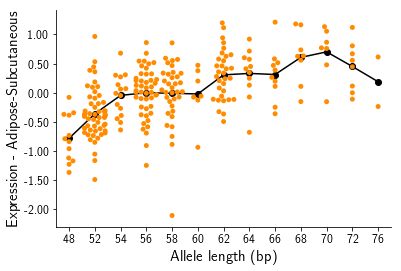

In [18]:
chrom = "chr11"
start = 297578
end = 297600
gene = "ENSG00000142102.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ATHL1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# RPUSD3
skin pigmentation gwas


Esophagus-Mucosa 1.7448787281806592e-08 -0.3457189602145574
WholeBlood 0.0032323060428837533 -0.16140535656138394
Lung 8.044625431657362e-09 -0.34938706256012825
Brain-Caudate 0.00017088482940972493 -0.3555817075541263
Muscle-Skeletal 2.06859269632349e-06 -0.25411868213369265
Nerve-Tibial 8.547970683761708e-05 -0.2402867472097527
Skin-SunExposed 0.00021153922611013955 -0.2144638212685774
Esophagus-Muscularis 8.915170228543072e-06 -0.30048412682675746
Thyroid 1.4347060700437005e-05 -0.26500063115376243
Artery-Tibial 9.746996429052775e-10 -0.3598508440668122
Brain-Cerebellum 0.0004904474701679773 -0.33131755181735834
Cells-Transformedfibroblasts 2.9864352523997397e-07 -0.3357787179245313
Adipose-Subcutaneous 1.3957174530372535e-06 -0.2897770493615587
Adipose-Visceral 0.0001285981762391599 -0.27286287983206925


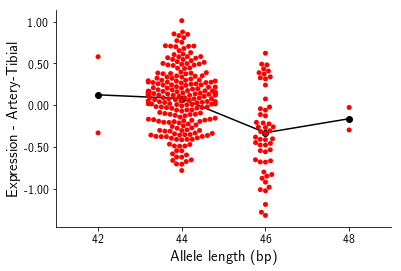

In [22]:
chrom = "chr3"
start = 9883164
end = 9883184
gene = "ENSG00000156990.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_RPUSD3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VWA7
   BLOOD PROTEIN GWAS

Muscle-Skeletal 7.260509115042453e-10 -0.3587176770253328
Artery-Tibial 0.00015502554922906982 -0.25012415931831383


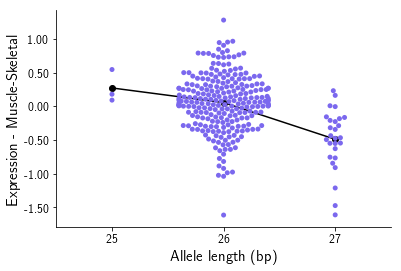

In [20]:
chrom = "chr6"
start = 31699087
end = 31699098
gene = "ENSG00000204396.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VWA7.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# DHRS4
bipolar

Artery-Aorta 0.0019985588885838733 -0.22520256522846305
Muscle-Skeletal 6.748341141187632e-05 -0.21595582152876489
Nerve-Tibial 0.00013854732538924044 -0.23686438623556866
Skin-SunExposed 2.0934958592133376e-09 0.3448067966041581
Esophagus-Muscularis 0.0006407098681956376 -0.2336967900896481
Artery-Tibial 1.3071112042472028e-08 -0.33854850605146203
Adipose-Subcutaneous 7.399069004748159e-05 -0.24279300986665225


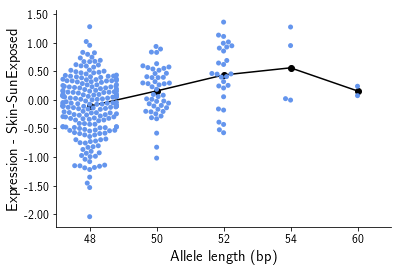

In [26]:
chrom = "chr14"
start = 24392239
end = 24392263
gene = "ENSG00000157326.14"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_DHRS4.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# IFT74
scz gwas

Lung 4.748902379152423e-08 -0.36024038915338746
Artery-Aorta 2.9122043722182257e-05 -0.319297571198492
Muscle-Skeletal 6.950452005424232e-05 -0.2325990305647463
Nerve-Tibial 5.397023752301034e-15 -0.4900534557706716
Skin-SunExposed 3.1111021321551086e-10 -0.3824006113030055
Esophagus-Muscularis 0.0002123730061243508 -0.2712493910737458
Thyroid 9.697865745119624e-11 -0.4167723905954094
Artery-Tibial 0.00017636280547622904 -0.2433200805428245
Brain-Cerebellum 0.0024011193606927857 -0.3214102747258223
Skin-NotSunExposed 1.3510760382237762e-09 -0.4425935374592507
Adipose-Subcutaneous 4.516919323879882e-06 -0.2946937400590896
Adipose-Visceral 0.0004778880707988044 -0.26893561223731804


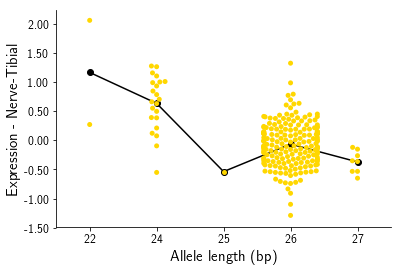

In [27]:
chrom = "chr9"
start = 26979150
end = 26979161
gene = "ENSG00000096872.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IFT74.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PRR12
gwas scz

Esophagus-Mucosa 6.711393636813602e-10 0.38131194593544215
Lung 6.30836488207937e-06 0.2812274575817545
Nerve-Tibial 0.0012323970211772007 0.2016559463167942
Skin-SunExposed 1.175747189389655e-11 0.3857991122470982
Thyroid 3.493237190532509e-15 0.4673040501132752
Skin-NotSunExposed 4.750055976423412e-09 0.3973796543553447
Adipose-Visceral 0.0004508323070361784 0.25538208933057466


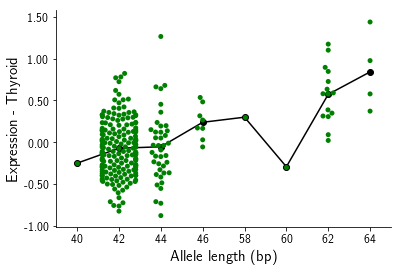

In [28]:
chrom = "chr19"
start = 50110619
end = 50110638
gene = "ENSG00000126464.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PRR12.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# ARPP19
gwas scz

Esophagus-Mucosa 3.1109577853526553e-21 0.5489379325602957
WholeBlood 9.231827253120986e-05 0.2126083276417827
Artery-Aorta 4.648236020334798e-13 0.4935486814943235
Muscle-Skeletal 6.396899351555801e-08 0.28807506747397305
Nerve-Tibial 1.1819630931880026e-20 0.5323996440468451
Skin-SunExposed 1.5243607907852434e-21 0.5152820876549652
Heart-LeftVentricle 1.3119471523757718e-07 0.3661129323302583
Thyroid 3.5746972789680354e-21 0.5419470790577885
Artery-Tibial 3.4939618171604863e-14 0.4373722579067922
Skin-NotSunExposed 4.54413246511223e-11 0.4380757014332468
Cells-Transformedfibroblasts 5.804823683281639e-13 0.4570759689656684
Adipose-Subcutaneous 9.901826052337064e-24 0.5612972169202302
Adipose-Visceral 1.849935777274995e-11 0.4603046306890484


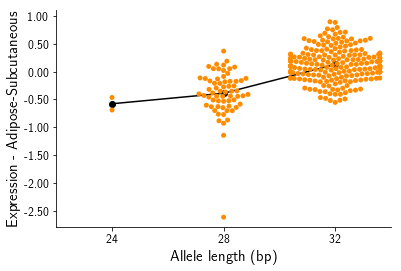

In [29]:
chrom = "chr15"
start = 52854833
end = 52854847
gene = "ENSG00000128989.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ARPP19.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VSIG2
gwas scz

Muscle-Skeletal 0.0017915488820116558 0.1692564332824802
Nerve-Tibial 0.007392020076654942 0.16545397873479867
Skin-SunExposed 5.993537488184197e-05 0.2326151713402061
Artery-Tibial 0.002537318458868361 0.18268118663184604
Cells-Transformedfibroblasts 0.005038504450630657 0.18761463830799624
Adipose-Subcutaneous 6.019106409844808e-08 0.32411681078318744


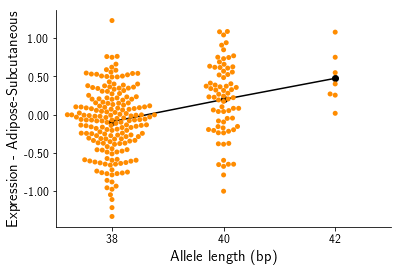

In [30]:
chrom = "chr11"
start = 124621018
end = 124621035
gene = "ENSG00000019102.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VSIG2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# FKBPL
scz gwas

WholeBlood 0.004187371134715581 -0.15869784391703026
Skin-SunExposed 1.4045971057133373e-05 0.2524237163103265


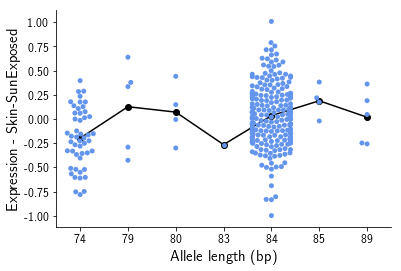

In [33]:
chrom = "chr6"
start = 32066234
end = 32066274
gene = "ENSG00000204315.3"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_FKBPL.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# DCLK3
autism gwas

Skin-NotSunExposed 3.682076145259664e-05 0.2874137799607485


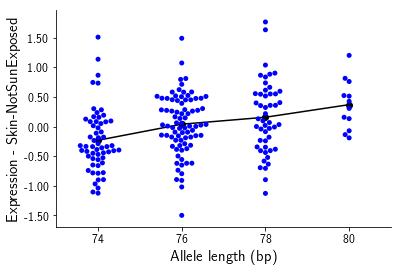

In [27]:
chrom = "chr3"
start = 36835922
end = 36835957
gene = "ENSG00000163673.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_DCLK3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# EXOG
scz gwas

Muscle-Skeletal 1.239713698089676e-06 -0.25942324743330786
Cells-Transformedfibroblasts 0.00026724027352330315 -0.2445278093488739


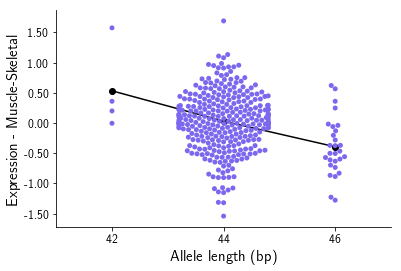

In [34]:
chrom = "chr3"
start = 38476818
end = 38476838
gene = "ENSG00000157036.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_EXOG.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# GLS
blood gwas

Esophagus-Mucosa 5.059282945521411e-06 -0.2867960625608881
Muscle-Skeletal 4.562020017696082e-09 -0.3142642099094985
Nerve-Tibial 0.0039066339104463325 -0.17906509667658835
Esophagus-Muscularis 0.00029763147944741116 -0.24896060983340795
Heart-LeftVentricle 0.00033731520658148784 -0.2573732588425641
Adipose-Subcutaneous 0.00017868697786645754 -0.2282333774524605


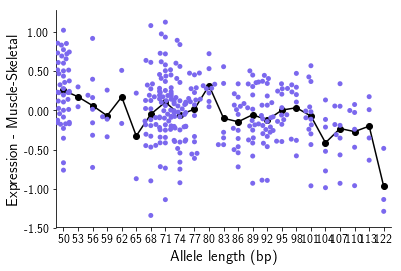

In [35]:
chrom = "chr2"
start = 191745599
end = 191745646
gene = "ENSG00000115419.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_GLS.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PCSK9
gwas ldl

WholeBlood 4.991449330755587e-05 -0.22003491841534192
Lung 0.0075843042093467206 -0.1658814791504925
Brain-Cerebellum 0.006320535919911228 -0.2624229688397727


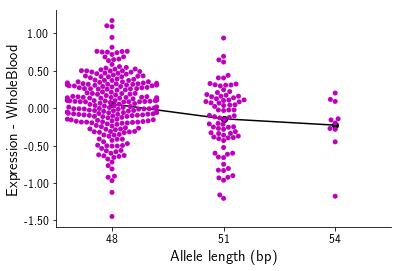

In [36]:
chrom = "chr1"
start = 55505553
end = 55505575
gene = "ENSG00000169174.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PCSK9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# ASCC2
gwas
bipolar

WholeBlood 0.0004081635520371792 0.19405614764307588
Brain-Cerebellum 1.1147113959663748e-05 0.4124781661518796


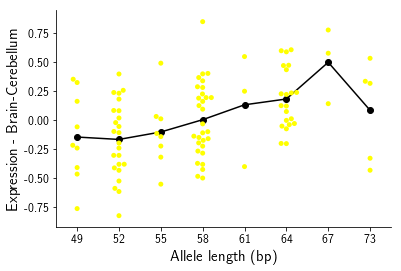

In [46]:
chrom = "chr22"
start = 30234193
end = 30234217
gene = "ENSG00000100325.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ASCC2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# TMEM158
gwas scz

Brain-Cerebellum 1.6339004475994153e-06 -0.5037646418625312


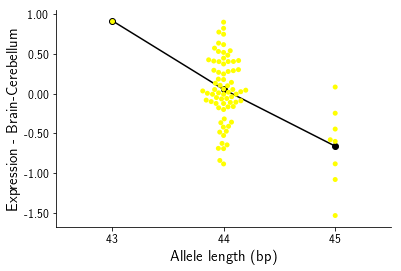

In [38]:
chrom = "chr3"
start = 45297762
end = 45297782
gene = "ENSG00000249992.1"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_TMEM158.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CCDC137
gwas cholesterol

Esophagus-Mucosa 4.185168062815647e-06 0.30393102752635226
WholeBlood 7.12650419211863e-10 0.35066409182094044
Lung 1.912194626968764e-10 0.40818565696801545
Artery-Aorta 1.7512384442686553e-06 0.3611449068248533
Nerve-Tibial 3.5391464010534315e-08 0.350724945278029
Skin-SunExposed 8.157450492113927e-07 0.3013232432815384
Esophagus-Muscularis 2.223058830646622e-05 0.30636601712620537
Heart-LeftVentricle 0.007548194794949495 0.20019402248215154
Thyroid 1.5788172216903009e-06 0.3072136546607862
Skin-NotSunExposed 3.8971520712025266e-05 0.3015353802850565
Adipose-Subcutaneous 3.536608511772432e-07 0.32161378877125485
Adipose-Visceral 2.84996450348151e-05 0.31509482386380444


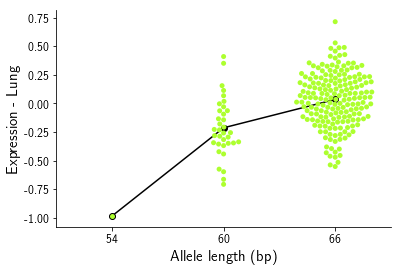

In [25]:
chrom = "chr17"
start = 79667664
end = 79667695
gene = "ENSG00000185298.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CCDC137.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# L1TD1
gwas pediatric bone

Esophagus-Mucosa 0.002371859515475145 -0.1994697286423544
Lung 5.874753738563325e-07 -0.32097175289751545
Artery-Aorta 4.2225446238689225e-08 -0.4085647269530128
Muscle-Skeletal 6.68799996761699e-07 -0.28002927517480874
Nerve-Tibial 1.1321902546122027e-25 -0.6122814616773267
Skin-SunExposed 3.781866912819568e-15 -0.457258463787894
Esophagus-Muscularis 2.1428061042287465e-14 -0.5196653731763242
Thyroid 4.026677993035952e-17 -0.5150926279789009
Artery-Tibial 2.512913347644224e-13 -0.4427073141169179
Skin-NotSunExposed 3.776219304197391e-08 -0.3938716953119884
Cells-Transformedfibroblasts 3.6958883643334884e-23 -0.6297079103810029
Adipose-Subcutaneous 6.6144068831420764e-24 -0.5900643155911631
Adipose-Visceral 3.3799141608050397e-12 -0.5024761613503977


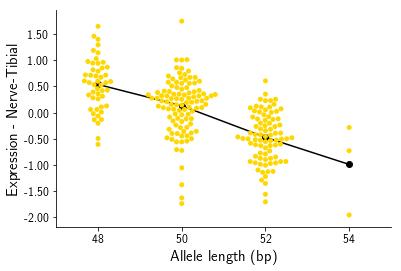

In [23]:
chrom = "chr1"
start = 62650593
end = 62650617
gene = "ENSG00000240563.1"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_L1TD1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# FAM154B
cognitive ability gwas

Esophagus-Mucosa 2.4001669816811903e-07 -0.33686745596229634
WholeBlood 3.6827153910353844e-11 -0.3722329458345276
Lung 0.00327303990286567 -0.1943992747533036
Artery-Aorta 2.948513517978429e-11 -0.4828937136252156
Muscle-Skeletal 1.1542215615277694e-05 -0.2506418800860439
Nerve-Tibial 2.4509914146152347e-08 -0.35818030537360285
Skin-SunExposed 1.1262023382531927e-08 -0.34426222405742657
Esophagus-Muscularis 0.00013308151333712312 -0.2715956891643639
Heart-LeftVentricle 1.0468019102176264e-09 -0.441763333475821
Thyroid 2.08981841205612e-07 -0.3370244520267596
Artery-Tibial 7.87125713775114e-11 -0.4015508357689577
Brain-Cerebellum 0.000494083614178529 -0.35798296072300395
Skin-NotSunExposed 2.6603695357651003e-10 -0.4544597997145975
Cells-Transformedfibroblasts 5.506867838025484e-10 -0.4188679798515417
Adipose-Subcutaneous 1.0193608413700073e-07 -0.33669940563641315
Adipose-Visceral 6.630726435780477e-08 -0.4076473637654385


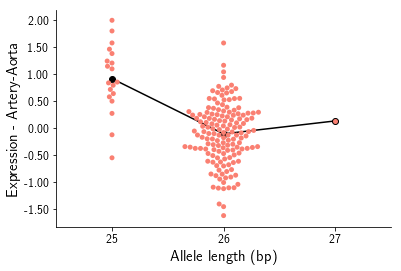

In [21]:
chrom = "chr15"
start = 82475166
end = 82475177
gene = "ENSG00000188659.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_FAM154B.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# NRBP2
SCZ gwas

Skin-SunExposed 0.005350701649980046 -0.16937224948983304
Thyroid 7.901385761986984e-05 0.25407189644284073


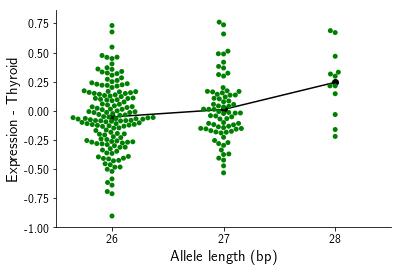

In [9]:
chrom = "chr8"
start = 144839147
end = 144839158
gene = "ENSG00000185189.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NRBP1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# NLRX1
platelet count


Cells-Transformedfibroblasts 0.00023736610130911933 0.2493208699802991


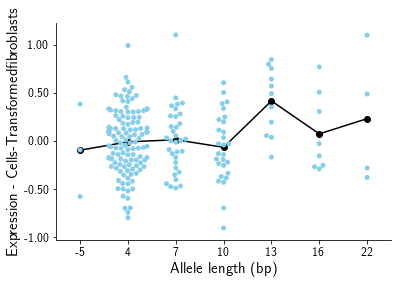

In [12]:
chrom = "chr11"
start = 119077000
end = 119077000
gene = "ENSG00000160703.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NLRX1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# SLC36A1
basophil perc gwas

Skin-SunExposed 1.0493718491097452e-16 0.4688129134561948
Adipose-Visceral 5.277235398258113e-07 0.3635284319275533
Adipose-Subcutaneous 4.595197997388511e-13 0.4335625383093324
Thyroid 1.1172355363734894e-22 0.567132316593502
WholeBlood 4.985878972190114e-13 0.3916737404221777
Artery-Tibial 5.1157162563565815e-14 0.4437336174928944
Nerve-Tibial 8.782494133869328e-14 0.4478207427918647
Esophagus-Mucosa 8.542845236578954e-06 0.28064660512933226
Artery-Aorta 6.698045980176985e-07 0.35669407417977744
Lung 1.7760292965720314e-14 0.464740791648959
Muscle-Skeletal 0.002530850345695498 0.1679951845063919
Heart-LeftVentricle 0.0003562076470956366 0.2563847622610408
Esophagus-Muscularis 9.211279672433607e-12 0.4549059947282375
Cells-Transformedfibroblasts 0.001103534675314384 0.22310151112802085
Skin-NotSunExposed 6.857084709486592e-07 0.346714771992448


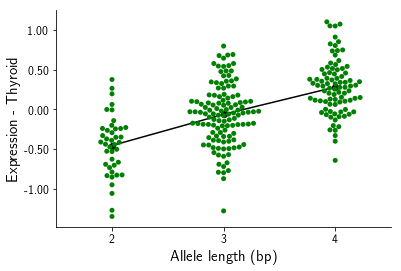

In [13]:
chrom = "chr5"
start = 150848654
end = 150848654
gene = "ENSG00000123643.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SLC36A1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# SIGLEC5
blood protein gwas

WholeBlood 9.931570643516584e-09 -0.3098510005941527


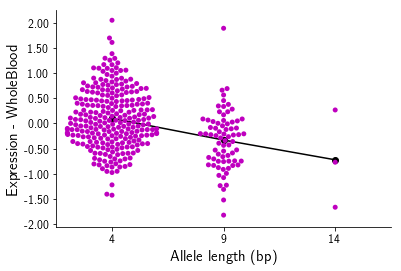

In [14]:
chrom = "chr19"
start = 52130149
end = 52130149
gene = "ENSG00000105501.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SIGLEC5.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# GPD1L
scz gwas

Thyroid 1.125566104796442e-20 0.5405704422090214
Esophagus-Mucosa 5.123229796000169e-06 0.2860729563755484
Lung 6.0023311978711925e-06 0.28077023011786073


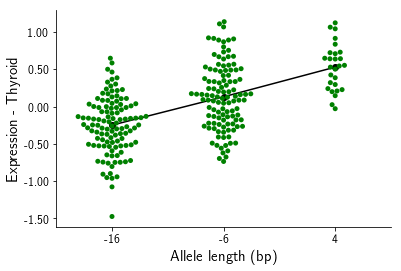

In [15]:
chrom = "chr3"
start = 32083114
end = 32083114
gene = "ENSG00000152642.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_GPD1L.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# SERINC2
heart rate https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5832790/

Adipose-Visceral 0.0011080364842690146 0.2366970239971613
Adipose-Subcutaneous 1.0418054480828764e-05 0.2701167466755467
WholeBlood 3.996586951213779e-13 0.39031896275652295
Artery-Tibial 1.5650395645447276e-10 0.3813761177638634
Esophagus-Mucosa 0.0036878029180786717 0.18753355470156666
Artery-Aorta 8.725958006304493e-07 0.3550714187027919
Lung 0.004993217899405453 0.17669159320770714
Muscle-Skeletal 0.00044106571421935286 0.19324132128743
Esophagus-Muscularis 0.00017354905819911437 0.2624725465694134
Cells-Transformedfibroblasts 3.5990561318678418e-09 0.3896513121765178


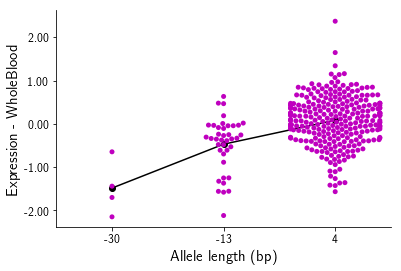

In [16]:
chrom = "chr1"
start = 31886001
end = 31886001
gene = "ENSG00000168528.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SERINC2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# IRF5
autoimmune gwas

Skin-SunExposed 8.750973930566279e-09 0.3303154672824102
Adipose-Visceral 0.0023021977000203552 0.2210304624637015
Adipose-Subcutaneous 0.004852085661823441 0.17319522934411444
Thyroid 7.199836320260566e-08 0.3288331213077018
WholeBlood 2.460512158718625e-15 0.4196161707481047
Artery-Tibial 3.0661122382709327e-07 0.30713426070748057
Nerve-Tibial 1.0973551762069028e-07 0.3256480487050753
Esophagus-Mucosa 5.978753089285937e-10 0.3823523166163335
Artery-Aorta 0.0010797254791681434 0.2372137907010804
Lung 8.03556247046095e-08 0.33141699044003303
Muscle-Skeletal 0.0066400717428441065 0.14892611901270705
Brain-Caudate 0.0051381528137544215 0.2724715509161179
Esophagus-Muscularis 0.001742564190891924 0.21790734461555167
Cells-Transformedfibroblasts 1.5344972627196415e-05 0.2908492183378725
Skin-NotSunExposed 0.00017710764787707344 0.2596053352561553


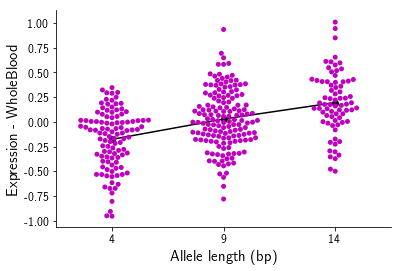

In [17]:
chrom = "chr7"
start = 128577915
end = 128577915
gene = "ENSG00000128604.14"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IRF5.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CARD9
gwas

WholeBlood 0.006778809077851694 -0.15060829306819495
Muscle-Skeletal 2.872941418694877e-05 0.2270958025884247
Cells-Transformedfibroblasts 0.0019384260051748504 0.21024261012669532


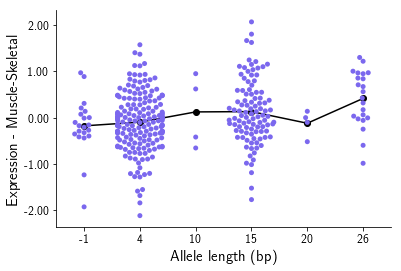

In [18]:
chrom = "chr9"
start = 139258185
end = 139258185
gene = "ENSG00000187796.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CARD9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# IGSF9B
gwas scz/asd

Thyroid 4.545720067990943e-16 -0.4746310865989592
WholeBlood 1.767376132816974e-06 -0.25912277877086937
Artery-Tibial 0.0019627255699341283 -0.1865753970666892
Nerve-Tibial 0.0038121087966161656 -0.17816852129272426


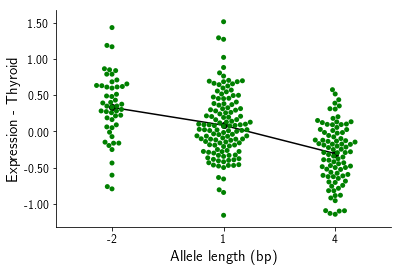

In [19]:
chrom = "chr11"
start = 133820762
end = 133820762
gene = "ENSG00000080854.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IGSF9B.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# RASIP1
crohn's disease gwas

Skin-SunExposed 2.336103590388474e-07 -0.29601909022821554
Esophagus-Mucosa 8.667466186815802e-15 -0.4645765736392843
Cells-Transformedfibroblasts 5.889123728669612e-12 -0.4441957678605821
Skin-NotSunExposed 0.0005649846211891737 -0.2370793752057113


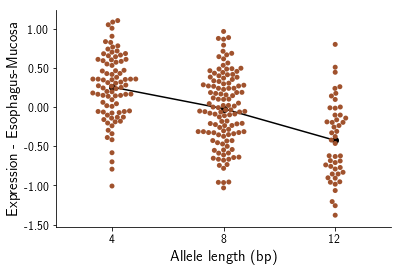

In [21]:
chrom = "chr19"
start = 49232030
end = 49232030
gene = "ENSG00000105538.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_RASIP1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# MKRN2
cholesterol gwas

Skin-SunExposed 8.374567575091696e-07 -0.2817145885903978
Adipose-Subcutaneous 0.001073849543360352 -0.19870617423347264
WholeBlood 2.2507701841385142e-05 -0.23034787386603384
Artery-Tibial 2.6644371334755414e-15 -0.4541984857760834
Esophagus-Mucosa 1.9155238850882357e-06 -0.2953263464374561
Artery-Aorta 4.553835844360116e-06 -0.32644733156187666
Lung 0.0018787509778552683 -0.19340611126942453
Muscle-Skeletal 8.350580976282615e-27 -0.5371204761028917
Heart-LeftVentricle 1.1284291683169515e-06 -0.33866833219188
Esophagus-Muscularis 0.0022227120032904226 -0.20898598848040112
Cells-Transformedfibroblasts 4.201520142260756e-07 -0.3310724935467212
Skin-NotSunExposed 2.006827027749236e-06 -0.3248831530488701


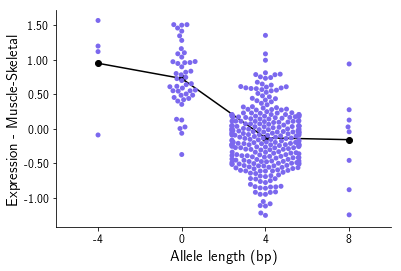

In [22]:
chrom = "chr3"
start = 12625265
end = 12625265
gene = "ENSG00000075975.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MKRN2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CCDC137,OXLD1
cholesterol

Skin-SunExposed 8.157450492113927e-07 0.3013232432815384
Adipose-Visceral 2.84996450348151e-05 0.31509482386380444
Adipose-Subcutaneous 3.536608511772432e-07 0.32161378877125485
Thyroid 1.5788172216903009e-06 0.3072136546607862
WholeBlood 7.12650419211863e-10 0.35066409182094044
Nerve-Tibial 3.5391464010534315e-08 0.350724945278029
Esophagus-Mucosa 4.185168062815647e-06 0.30393102752635226
Artery-Aorta 1.7512384442686553e-06 0.3611449068248533
Lung 1.912194626968764e-10 0.40818565696801545
Heart-LeftVentricle 0.007548194794949495 0.20019402248215154
Esophagus-Muscularis 2.223058830646622e-05 0.30636601712620537
Skin-NotSunExposed 3.8971520712025266e-05 0.3015353802850565


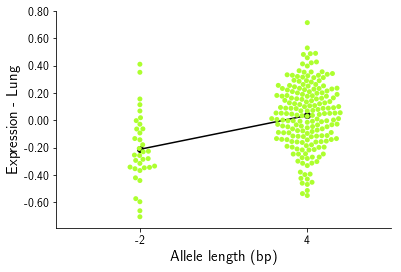

In [23]:
chrom = "chr17"
start = 79667664
end = 79667664
gene = "ENSG00000185298.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CCDC137.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# LCAT
cholesterol gwas

WholeBlood 2.3596863738620944e-08 -0.3328379469245061


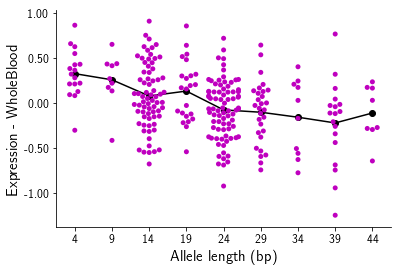

In [24]:
chrom = "chr16"
start = 68014740
end = 68014740
gene = "ENSG00000213398.3"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_LCAT.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# NPRL3
blood gwas

Brain-Cerebellum 7.588008143862597e-10 -0.5602394816225938
Skin-SunExposed 1.0453210019715316e-15 -0.4549085907093791
Adipose-Visceral 3.929112756560687e-11 -0.4680633168836372
Adipose-Subcutaneous 1.556821459615462e-22 -0.5581932319276508
Thyroid 7.357110677658813e-13 -0.4332171676056555
Artery-Tibial 3.3769169221837104e-09 -0.35308443675271456
Nerve-Tibial 4.895001747449874e-20 -0.5392629727990816
Esophagus-Mucosa 4.873900487174692e-13 -0.4435658624573575
Artery-Aorta 6.7063762981744224e-18 -0.5808707909612547
Lung 3.9410244756731695e-18 -0.5149822974129588
Muscle-Skeletal 5.684921218874342e-15 -0.41632652023924505
Brain-Caudate 3.7236817102079556e-08 -0.5144719393931253
Heart-LeftVentricle 6.18290372557741e-11 -0.4526461939710994
Esophagus-Muscularis 2.581294069633389e-17 -0.5458515297230118
Cells-Transformedfibroblasts 2.7142231183344722e-08 -0.3686887492262511
Skin-NotSunExposed 3.0272502608744046e-13 -0.4880465251375807


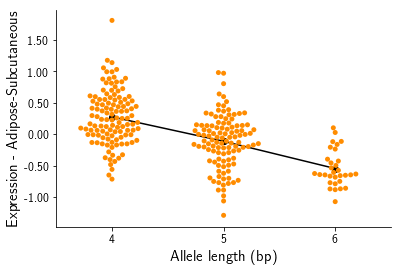

In [25]:
chrom = "chr16"
start = 186525
end = 186525
gene = "ENSG00000103148.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NPRL3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PAX8

Skin-SunExposed 6.875337293660186e-24 -0.5416394139165275
Adipose-Visceral 1.8303025402972879e-16 -0.5483356239084642
Adipose-Subcutaneous 5.596743971310913e-26 -0.5847604828109519
WholeBlood 1.0492893382714712e-19 -0.4694083048803913
Artery-Tibial 3.3394411804900586e-24 -0.5627358354169372
Nerve-Tibial 1.2258659905196505e-29 -0.6236417968408379
Esophagus-Mucosa 7.620450672701108e-21 -0.5425714830131302
Artery-Aorta 2.426861798677945e-25 -0.6608330035014415
Lung 2.4519282289986135e-16 -0.4808976126102635
Muscle-Skeletal 1.949902951589941e-13 -0.3841720088961015
Brain-Caudate 3.348384644539741e-06 -0.4321626658624211
Heart-LeftVentricle 1.2471119389384633e-15 -0.5283423965635321
Esophagus-Muscularis 1.472718522989775e-19 -0.5675508405044395
Cells-Transformedfibroblasts 3.7644449083105677e-16 -0.5107578702929808
Skin-NotSunExposed 3.2713032736089117e-21 -0.5961589409889411


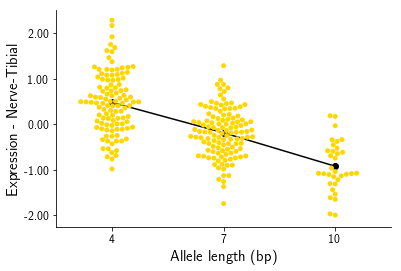

In [26]:
chrom = "chr2"
start = 113984226
end = 113984226
gene = "ENSG00000125618.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PAX8.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# RASGRP3

Brain-Cerebellum 4.528566303648316e-06 0.4487466372925006
Skin-SunExposed 1.0010357910295393e-09 0.3596173922910565
Adipose-Visceral 2.0575228217641157e-05 0.317649189876144
Thyroid 3.4514916052873245e-17 0.5048942285918738
WholeBlood 0.0022207006614131165 0.1739634389258655
Artery-Tibial 0.0064795486090845926 0.17007952896283934
Nerve-Tibial 1.7925323729431408e-06 0.3001822923684254
Esophagus-Mucosa 5.59142644034964e-06 0.29074484081984475
Artery-Aorta 0.005517750576229175 0.21198327237815034
Lung 2.435084332736508e-07 0.32711371759395985
Muscle-Skeletal 1.866858535407385e-07 0.28943533736863297
Heart-LeftVentricle 7.567050280550641e-15 0.5321951277546911
Esophagus-Muscularis 3.830379078639391e-05 0.29180204811336113
Skin-NotSunExposed 1.1970907689270026e-09 0.42101267139423626


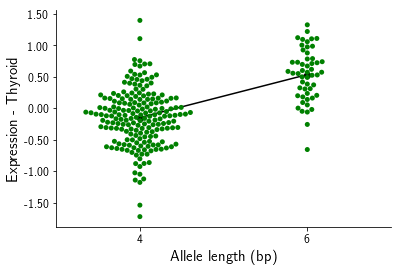

In [28]:
chrom = "chr2"
start = 33762260
end = 33762260
gene = "ENSG00000152689.13"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_RASGRP3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VGLL2

Esophagus-Mucosa 4.878328526986629e-09 0.3700332758225506


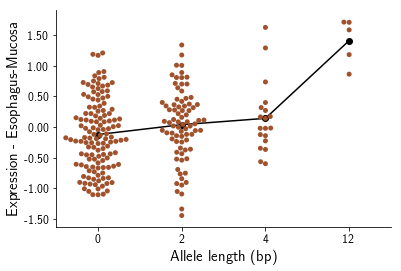

In [29]:
chrom = "chr6"
start = 117524057
end = 117524057
gene = "ENSG00000170162.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VGLL2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# TMPRSS9

Skin-SunExposed 0.0036314173646097257 0.17451900375657625
WholeBlood 6.495764798398849e-14 0.4111896705464189


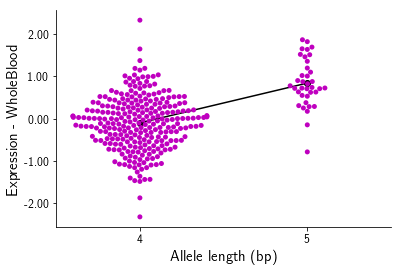

In [30]:
chrom = "chr19"
start = 2421294
end = 2421294
gene = "ENSG00000178297.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_TMPRSS9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# HTATIP2

Brain-Cerebellum 0.003808393983317469 0.2787639177309794
Adipose-Visceral 1.6435970487329048e-14 0.5228327675545665
Adipose-Subcutaneous 2.5016008651659257e-34 0.657616562060935
WholeBlood 0.007640847290725506 0.14682728208735293
Artery-Tibial 6.3547866104516485e-18 0.4935622835463453
Nerve-Tibial 5.977624934532001e-32 0.6476304313862666
Esophagus-Mucosa 3.7495079998907177e-05 -0.25912221318108397
Artery-Aorta 9.651960729008126e-15 0.5291841782258672
Lung 6.871457442180584e-05 0.2466308523494353
Muscle-Skeletal 4.7615915598599604e-08 0.2915862523038166
Brain-Caudate 0.0034461303426877032 0.2803560046929972
Heart-LeftVentricle 9.164537727197323e-12 0.4621723421602947
Esophagus-Muscularis 1.6834170610711692e-19 0.571259588851503
Cells-Transformedfibroblasts 2.5104935713554784e-32 0.6891168908185997


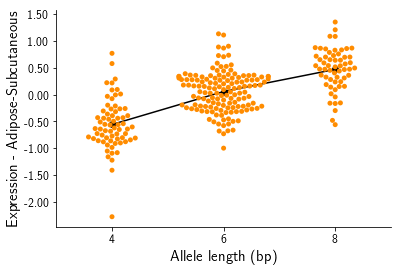

In [31]:
chrom = "chr11"
start = 20384871
end = 20384871
gene = "ENSG00000109854.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_HTATIP2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# SMYD4
Blood_protein_levels

Brain-Cerebellum 0.00285710709529168 0.28968141549375737
Skin-SunExposed 3.3600434211180483e-08 0.3151247147400843
Adipose-Visceral 0.0003020049505121367 0.2600375220450829
Adipose-Subcutaneous 5.831898564703277e-08 0.3261897170118524
Thyroid 2.811584850136219e-15 0.4654720816937326
WholeBlood 0.0014009946054437238 0.17594695180437836
Artery-Tibial 2.938920275448392e-07 0.3054014030953813
Nerve-Tibial 4.3732088351863444e-07 0.3060524802334957
Esophagus-Mucosa 0.00017496519043970463 0.2361093455448671
Lung 7.197481798495317e-05 0.2464418780399161
Muscle-Skeletal 2.9399588268090413e-05 0.2248398869226687
Brain-Caudate 0.0012924628030778276 0.30852289371198904
Heart-LeftVentricle 0.000489297189600156 0.2480002360964056
Esophagus-Muscularis 7.198562515242941e-06 0.3055360864159952
Skin-NotSunExposed 2.207557263778761e-05 0.2916450731939681


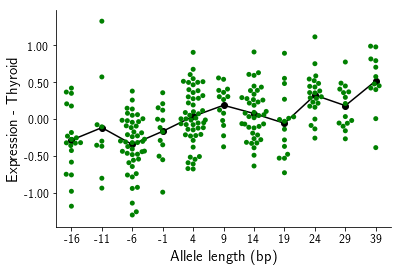

In [32]:
chrom = "chr17"
start = 1682774
end = 1682774
gene = "ENSG00000186532.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SMYD4.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# EXOC3

Brain-Cerebellum 7.669455550360116e-05 0.3963426439408418
Adipose-Visceral 4.681022686265251e-05 0.30692649052426235
Adipose-Subcutaneous 0.0023620152813510213 0.19418811210944506
Thyroid 0.002345337057192233 0.1971564217707783
WholeBlood 1.3539198989883802e-10 0.3637452905994316
Artery-Tibial 3.580823408181425e-11 0.4081662925159461
Esophagus-Mucosa 9.574701949102703e-08 0.34722480295380165
Artery-Aorta 0.00019034727945445702 0.2899973792239334
Lung 3.869563999237348e-12 0.4403922724674031
Muscle-Skeletal 6.050752487079279e-13 0.3980221988102511
Heart-LeftVentricle 0.002285371492314771 0.2291544073833147
Esophagus-Muscularis 4.529487478854264e-11 0.4565877628674536


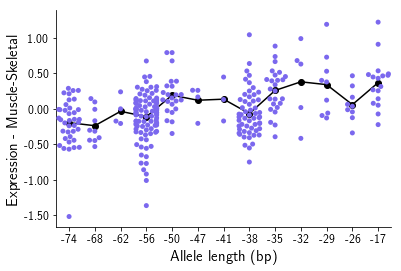

In [33]:
chrom = "chr5"
start = 443336
end = 443336
gene = "ENSG00000180104.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_EXOC3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)